In [1]:
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# Read the NLS aligned motifs

file_path ='./NLS_sequences_padded.txt'

NLS_sequences = []

with open(file_path, 'r', encoding = 'utf-8') as f:
  for line in f:
    NLS_sequences.append(line.strip())

In [3]:
NLS_sequences

['KRTVETEAVQMLKDIKKE------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------',
 'KLKEKLK-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------',
 'RREFGDSKRVFGERRRN-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------',
 'KKR---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------',
 'KKR---------------------------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
background = {'A':0.0777,
              'C':0.0157,
              'D':0.053,
              'E':0.0656,
              'F':0.0405,
              'G':0.0691,
              'H':0.0227,
              'I':0.0591,
              'K':0.0595,
              'L':0.096,
              'M':0.0238,
              'N':0.0427,
              'P':0.0469,
              'Q':0.0393,
              'R':0.0526,
              'S':0.0694,
              'T':0.055,
              'V':0.0667,
              'W':0.0118,
              'Y':0.0311}
# background = {'M': 0.02211207580407797,
#               'P': 0.07190226876090751,
#               'Y': 0.02350057717452554,
#               'K': 0.07186287865110758,
#               'L': 0.08816710159912904,
#               'E': 0.07915770815211147,
#               'V': 0.05594599178278543,
#               'A': 0.0684939300934968,
#               'C': 0.01752750469125266,
#               'T': 0.04976502705334625,
#               'S': 0.09052722567797492,
#               'G': 0.06453522405860374,
#               'D': 0.052761957907291,
#               'N': 0.035706040363920846,
#               'Q': 0.05032743028771193,
#               'R': 0.05507175017917029,
#               'I': 0.03830797595014963,
#               'F': 0.031072231613845622,
#               'H': 0.02474574231209003,
#               'W': 0.008509357886501775}


In [131]:
standard_amino_acids = 'ACDEFGHIKLMNPQRSTVWY'  # 20 standard amino acids

In [134]:
# This section of the code utilizes modified components of Position-Specific Scoring Matrices from Biopython.
# Biopython is distributed under the Biopython License and BSD 3-Clause License.
# More details can be found at: https://biopython.org


class GenericPositionMatrix:
    """Base class for position matrix operations on protein motifs."""
    

    def __init__(self, aligned_sequences):
        self.length = len(aligned_sequences[0])  
        self.standard_amino_acids = standard_amino_acids
        self._validate_sequences(aligned_sequences)  
        self.matrix = self._calculate_position_counts(aligned_sequences)
        self.num_sequences = len(aligned_sequences)
        self.effective_length = self.find_effective_length()  # Calculate effective length after all setups

    def _validate_sequences(self, aligned_sequences):
        if not all(len(seq) == self.length for seq in aligned_sequences):
            raise ValueError("Data has inconsistent lengths.")

    def _calculate_position_counts(self, aligned_sequences):
        aa_counts = defaultdict(lambda: [0] * self.length)
        for seq in aligned_sequences:
            for position, amino_acid in enumerate(seq):
                aa_counts[amino_acid][position] += 1
        return aa_counts

    def find_effective_length(self, threshold=0.9):
        """Dynamically determine the effective NLS length, excluding padding."""
        for position in range(self.length - 1, -1, -1):
            padding_ratio = self.matrix['-'][position] / self.num_sequences
            if padding_ratio < threshold:
                return position + 1  # Return length excluding padding
        return self.length  # Return full length if no padding detected

class PositionWeightMatrix(GenericPositionMatrix):
    """Supports frequency calculations for protein motifs."""

    def normalize(self, background_frequencies=background, pseudocount_factor=1):
        normalized_matrix = {aa: [0.0] * self.effective_length for aa in self.standard_amino_acids}
        total_counts = [0] * self.effective_length

        for aa in self.standard_amino_acids:
            for position in range(self.effective_length):
                pseudocount = background_frequencies[aa] * pseudocount_factor
                count = self.matrix.get(aa, [0] * self.effective_length)[position] + pseudocount
                normalized_matrix[aa][position] = count
                total_counts[position] += count

        for aa, counts in normalized_matrix.items():
            for position, count in enumerate(counts):
                normalized_matrix[aa][position] = count / total_counts[position] if total_counts[position] else 0

        self.matrix = normalized_matrix

    def log_odds(self, background_frequencies=background):
        background_frequencies = background
        # or {aa: 1.0 / len(self.standard_amino_acids) for aa in self.standard_amino_acids}
        log_odds_matrix = {aa: [0] * self.effective_length for aa in self.standard_amino_acids}

        for aa in self.standard_amino_acids:
            for position in range(self.effective_length):
                p = self.matrix[aa][position]
                b = background_frequencies.get(aa, 0)
                score = math.log(p / b, 2) if p > 0 else -math.inf
                log_odds_matrix[aa][position] = score

        return PositionSpecificScoringMatrix(log_odds_matrix, self.effective_length)

class PositionSpecificScoringMatrix:
    """Scores sequences against a Position Specific Scoring Matrix (PSSM)."""

    def __init__(self, matrix, length):
        self.matrix = matrix
        self.length = length
        self.standard_amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

    def __str__(self):
        lines = ["   " + " ".join(f"{i:6d}" for i in range(self.length))]
        for amino_acid in self.standard_amino_acids:
            line = f"{amino_acid}: " + " ".join(f"{self.matrix[amino_acid][i]:6.2f}" for i in range(self.length))
            lines.append(line)
        return "\n".join(lines)

    def calculate(self, sequence):
        """Calculate the PSSM score for a given protein sequence."""
        # Initial checks and setup
        sequence = sequence.upper()
        if any(aa not in self.standard_amino_acids for aa in sequence):
            raise ValueError("Sequence contains invalid amino acids for this PSSM.")

        scores = np.empty(len(sequence) - self.length + 1, dtype=np.float32)
        for offset in range(len(scores)):
            score = sum(self.matrix[aa][position] for position, aa in enumerate(sequence[offset:offset + self.length]) if aa in self.matrix)
            scores[offset] = score
        return scores

    def search(self, sequence, threshold=0.0):
        """Find hits in the sequence with PSSM score above a given threshold."""
        sequence = sequence.upper()
        potential_hits = []
        scores = self.calculate(sequence)
        for i, score in enumerate(scores):
            if score >= threshold:
                # yield start + i, score
                potential_hits.append((i, score))

        potential_hits.sort(key=lambda x: x[1], reverse=True)
        return potential_hits

In [135]:
fpm = PositionWeightMatrix(NLS_sequences)
fpm.normalize()  
pssm = fpm.log_odds()
print(pssm)

        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17
A:  -3.40  -1.20  -1.20  -1.14  -1.16  -1.39  -1.21  -0.31  -0.45  -0.37  -0.98  -0.66  -0.33  -1.97  -0.26  -0.53  -1.36  -0.57
C:  -2.42  -1.83  -1.41  -2.36  -1.59  -0.99  -1.39  -1.66  -1.09  -0.60  -1.17  -1.60   0.26  -0.16  -8.41  -8.31  -8.06  -0.43
D:  -2.00  -3.00  -1.52  -5.08  -0.97  -0.57  -0.88  -0.20  -0.53  -0.77  -1.51  -0.77  -1.13  -0.43  -1.35  -0.48  -2.21   0.51
E:  -2.39  -1.84  -1.08  -0.81  -0.35  -0.38  -0.56  -0.23   0.77   0.74   0.03   0.94  -0.22  -1.21  -1.15  -0.67  -0.95  -0.49
F:  -4.76  -4.18  -1.69  -1.40  -1.37  -2.03  -0.49  -1.03  -0.76  -0.96  -0.22  -2.95  -1.11  -0.26  -1.45  -2.65  -8.06  -0.48
G:  -2.31  -2.03  -0.94  -0.45  -0.79  -0.57  -1.04  -1.07  -0.91  -0.81  -0.31  -0.93  -0.88  -1.80  -0.96   0.14  -1.02  -0.98
H:  -1.63  -0.86  -0.62  -0.64  -0.38  -0.61   0.61   0.30  -1.04  -0.28   0.17  -1.55  -1.08   0

In [136]:
# Plot customized heatmap
def plot_heatmap(pssm, width=10, height=30):
    plt.figure(figsize=(width, height))
    ax = sns.heatmap(pssm, annot=False, cmap='viridis', linewidths=.5,
                    xticklabels=pssm.columns)


    ax.xaxis.tick_top()

    ax.set_xticklabels(pssm.columns, ha="left")
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True, labeltop=True)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Title and labels
    plt.title('PSSM Heatmap', y=1.05)
    plt.xlabel('Amino Acids', labelpad=20)
    plt.ylabel('Position')

    plt.tight_layout()

    plt.show()

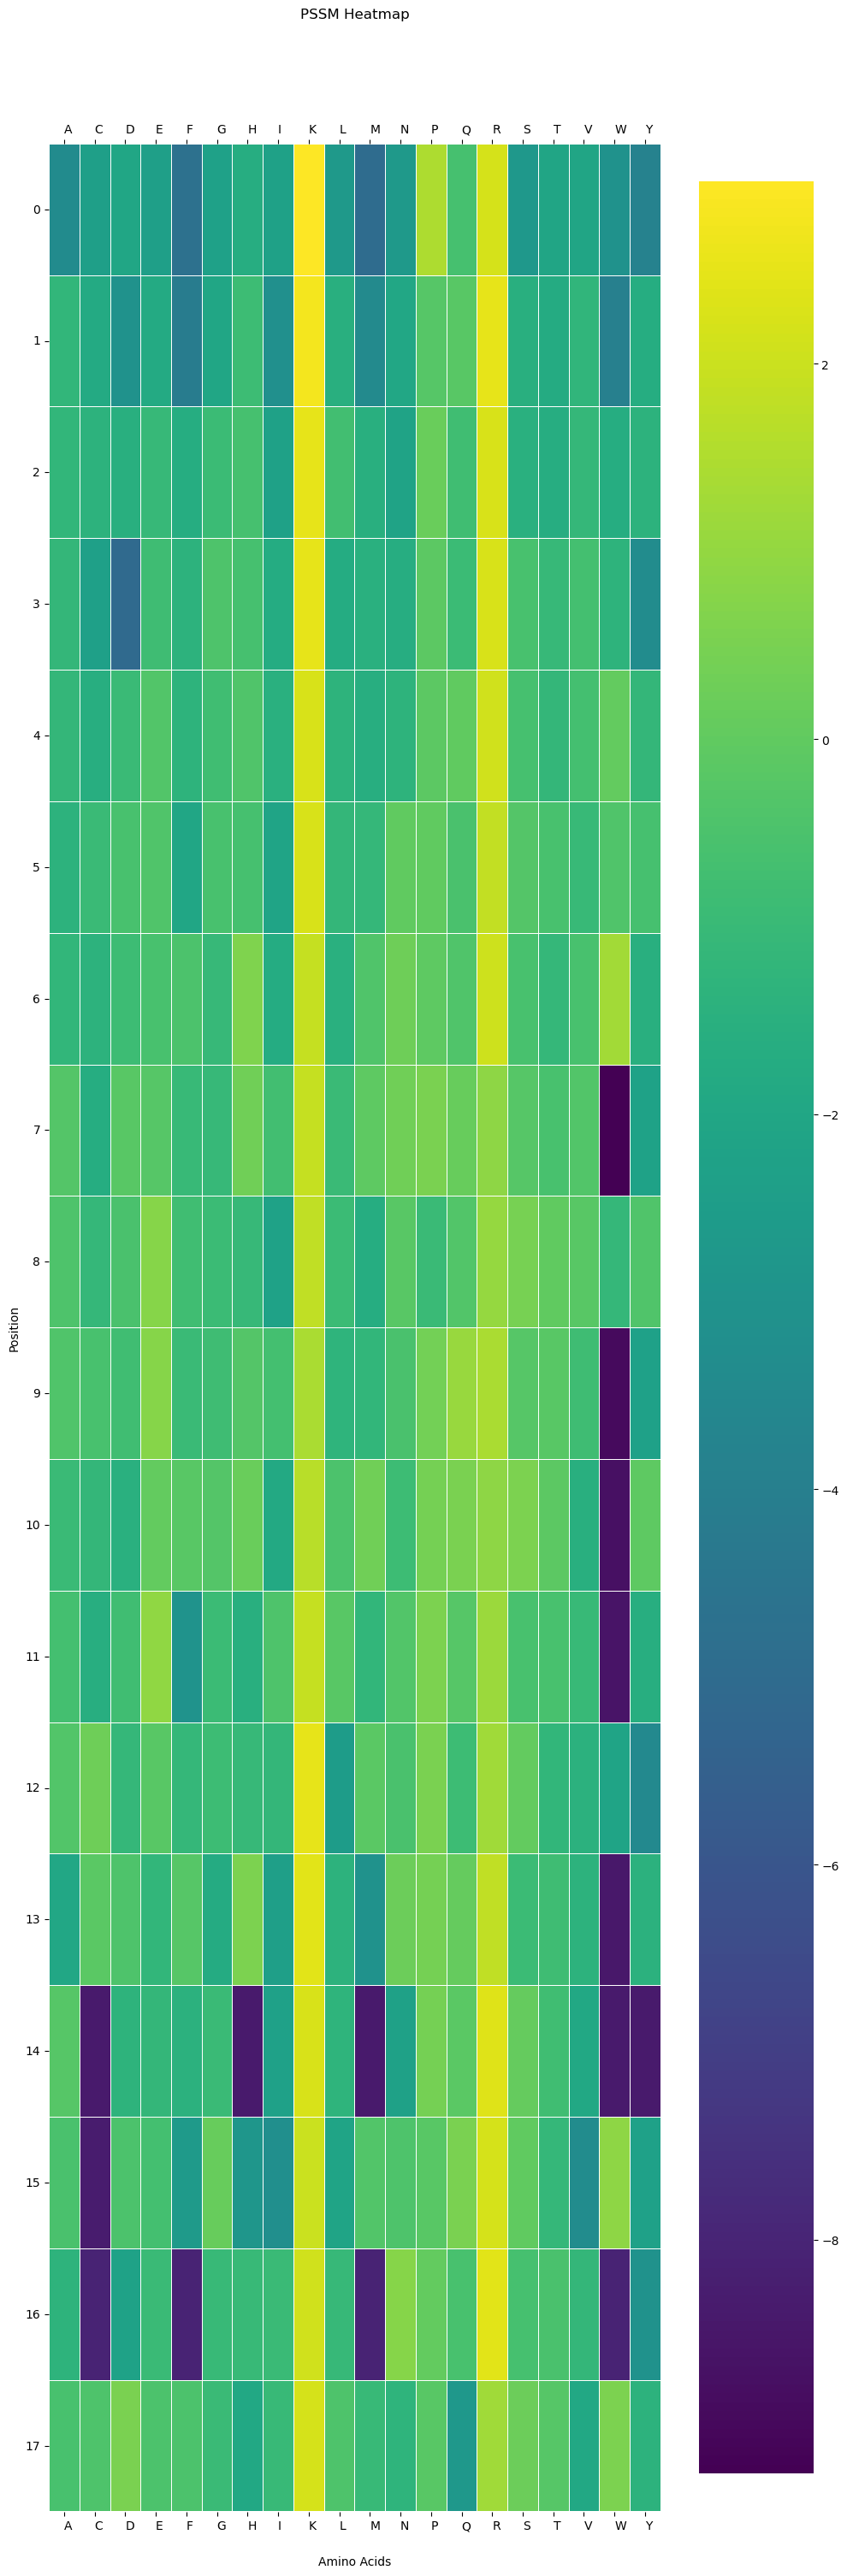

In [137]:
df_pssm = pd.DataFrame(pssm.matrix)

plot_heatmap(df_pssm,10,30)

In [138]:
def compute_scores(pssm, sequence, threshold=2):
    sequence_scores = pssm.calculate(sequence)
    results = pssm.search(sequence,threshold)
    return sequence_scores, results


In [139]:
sequence = """MSNVNLSVSDFWRVMMRVCWLVRQDSRHQRIRLPHLEAVVIGRGPETKITDKKCSRQQVQ
LKAECNKGYVKVKQVGVNPTSIDSVVIGKDQEVKLQPGQVLHMVNELYPYIVEFEEEAKN
PGLETHRKRKRSGNSDSIERDAAQEAEAGTGLEPGSNSGQCSVPLKKGKDAPIKKESLGH
WSQGLKISMQDPKMQVYKDEQVVVIKDKYPKARYHWLVLPWTSISSLKAVAREHLELLKH
MHTVGEKVIVDFAGSSKLRFRLGYHAIPSMSHVHLHVISQDFDSPCLKNKKHWNSFNTEY
FLESQAVIEMVQEAGRVTVRDGMPELLKLPLRCHECQQLLPSIPQLKEHLRKHWTQ"""

sequence = sequence.replace('\n','')


sequence_scores, results = compute_scores(pssm, sequence, threshold = 2)


print(f"The scores are {sequence_scores}")
print()
for index, score in results:
    print(f"Match begins at {index+1} with score {score} and amino acid {sequence[index]}")

The scores are [-30.31198    -31.35334    -31.729593   -27.698637   -28.633772
 -18.67158    -26.772833   -11.950617   -20.783901   -16.37563
 -19.165361   -10.606755   -14.605328    -9.7666025   -6.6036334
  -5.9131775   -3.9671738   -7.6530733   -7.3420134   -7.3363037
 -15.390048    -6.575034    -5.9958205  -13.371433   -10.859443
  -8.0693245   -4.370703    -6.1188035   -2.7276595   -7.5500145
  -5.9807024   -4.721002   -11.685133    -5.7046676  -10.519414
  -7.2277513   -4.530967   -10.373746    -9.941759    -9.36231
  -2.8288305    2.0211203   -2.3391495   -7.5914226    1.3503138
  -4.9850583   -1.5072048   -4.423934   -12.9065075   -6.5986357
  -5.0500636    0.88640904  -0.65136844  -5.4416323  -14.855409
   0.92963916 -10.9313135   -7.880858    -1.40938     -8.229595
  -4.835241    -8.465644   -11.86329     -8.240046    -6.083867
  -5.1415844   -6.164671   -11.268245   -10.834898    -7.851895
  -8.490782    -9.899975    -4.8334107  -17.333      -14.365383
 -13.652126   -10.1838

In [29]:
sequence = """MDGVSSEANEENDNIERPVRRRHSSILKPPRSPLQDLRGGNERVQESNALRNKKNSRRVS
FADTIKVFQTESHMKIVRKSEMEGCSAMVPSQLQLLPPGFKRFSCLSLPETETGENLLLI
QNKKLEDNYCEITGMNTLLSAPIHTQMQQKEFSIIEHTRERKHANDQTVIFSDENQMDLT
SSHTVMITKGLLDNPISEKSTKIDTTSFLANLKLHTEDSRMKKEVNFSVDQNTSSENKID
FNDFIKRLKTGKCSAFPDVPDKENFEIPIYSKEPNSASSTHQMHVSLKEDENNSNITRLF
REKDDGMNFTQCHTANIQTLIPTSSETNSRESKGNDITIYGNDFMDLTFNHTLQILPATG
NFSEIENQTQNAMDVTTGYGTKASGNKTVFKSKQNTAFQDLSINSADKIHITRSHIMGAE
THIVSQTCNQDARILAMTPESIYSNPSIQGCKTVFYSSCNDAMEMTKCLSNMREEKNLLK
HDSNYAKMYCNPDAMSSLTEKTIYSGEENMDITKSHTVAIDNQIFKQDQSNVQIAAAPTP
EKEMMLQNLMTTSEDGKMNVNCNSVPHVSKERIQQSLSNPLSISLTDRKTELLSGENMDL
TESHTSNLGSQVPLAAYNLAPESTSESHSQSKSSSDECEEITKSRNEPFQRSDIIAKNSL
TDTWNKDKDWVLKILPYLDKDSPQSADCNQEIATSHNIVYCGGVLDKQITNRNTVSWEQS
LFSTTKPLFSSGQFSMKNHDTAISSHTVKSVLGQNSKLAEPLRKSLSNPTPDYCHDKMII
CSEEEQNMDLTKSHTVVIGFGPSELQELGKTNLEHTTGQLTTMNRQIAVKVEKCGKSPIE
KSGVLKSNCIMDVLEDESVQKPKFPKEKQNVKIWGRKSVGGPKIDKTIVFSEDDKNDMDI
TKSYTIEINHRPLLEKRDCHLVPLAGTSETILYTCRQDDMEITRSHTTALECKTVSPDEI
TTRPMDKTVVFVDNHVELEMTESHTVFIDYQEKERTDRPNFELSQRKSLGTPTVICTPTE
ESVFFPGNGESDRLVANDSQLTPLEEWSNNRGPVEVADNMELSKSATCKNIKDVQSPGFL
NEPLSSKSQRRKSLKLKNDKTIVFSENHKNDMDITQSCMVEIDNESALEDKEDFHLAGAS
KTILYSCGQDDMEITRSHTTALECKTLLPNEIAIRPMDKTVLFTDNYSDLEVTDSHTVFI
DCQATEKILEENPKFGIGKGKNLGVSFPKDNSCVQEIAEKQALAVGNKIVLHTEQKQQLF
AATNRTTNEIIKFHSAAMDEKVIGKVVDQACTLEKAQVESCQLNNRDRRNVDFTSSHATA
VCGSSDNYSCLPNVISCTDNLEGSAMLLCDKDEEKANYCPVQNDLAYANDFASEYYLESE
GQPLSAPCPLLEKEEVIQTSTKGQLDCVITLHKDQDLIKDPRNLLANQTLVYSQDLGEMT
KLNSKRVSFKLPKDQMKVYVDDIYVIPQPHFSTDQPPLPKKGQSSINKEEVILSKAGNKS
LNIIENSSAPICENKPKILNSEEWFAAACKKELKENIQTTNYNTALDFHSNSDVTKQVIQ
THVNAGEAPDPVITSNVPCFHSIKPNLNNLNGKTGEFLAFQTVHLPPLPEQLLELGNKAH
NDMHIVQATEIHNINIISSNAKDSRDEENKKSHNGAETTSLPPKTVFKDKVRRCSLGIFL
PRLPNKRNCSVTGIDDLEQIPADTTDINHLETQPVSSKDSGIGSVAGKLNLSPSQYINEE
NLPVYPDEINSSDSINIETEEKALIETYQKEISPYENKMGKTCNSQKRTWVQEEEDIHKE
KKIRKNEIKFSDTTQDREIFDHHTEEDIDKSANSVLIKNLSRTPSSCSSSLDSIKADGTS
LDFSTYRSSQMESQFLRDTICEESLREKLQDGRITIREFFILLQVHILIQKPRQSNLPGN
FTVNTPPTPEDLMLSQYVYRPKIQIYREDCEARRQKIEELKLSASNQDKLLVDINKNLWE
KMRHCSDKELKAFGIYLNKIKSCFTKMTKVFTHQGKVALYGKLVQSAQNEREKLQIKIDE
MDKILKKIDNCLTEMETETKNLEDEEKNNPVEEWDSEMRAAEKELEQLKTEEEELQRNLL
ELEVQKEQTLAQIDFMQKQRNRTEELLDQLSLSEWDVVEWSDDQAVFTFVYDTIQLTITF
EESVVGFPFLDKRYRKIVDVNFQSLLDEDQAPPSSLLVHKLIFQYVEEKESWKKTCTTQH
QLPKMLEEFSLVVHHCRLLGEEIEYLKRWGPNYNLMNIDINNNELRLLFSSSAAFAKFEI
TLFLSAYYPSVPLPSTIQNHVGNTSQDDIATILSKVPLENNYLKNVVKQIYQDLFQDCHF
YH"""
sequence = sequence.replace('\n','')

sequence_scores, results = compute_scores(pssm, sequence, threshold=2)


print(f"The scores are {sequence_scores}")
print()
for index, score in results:
    print(f"Match begins at {index+1} with score {score} and amino acid {sequence[index]}")

The scores are [-12.798209 -11.500453  -9.037681 ... -15.34039  -29.760332 -25.500097]

Match begins at 17 with score 11.530954360961914 and amino acid R
Match begins at 16 with score 8.764081954956055 and amino acid E
Match begins at 1801 with score 6.621522903442383 and amino acid K
Match begins at 1083 with score 6.076837539672852 and amino acid P
Match begins at 1085 with score 5.963537693023682 and amino acid S
Match begins at 1785 with score 5.822895526885986 and amino acid S
Match begins at 1940 with score 5.244018077850342 and amino acid R
Match begins at 1799 with score 5.2260541915893555 and amino acid K
Match begins at 246 with score 5.184289932250977 and amino acid K
Match begins at 1953 with score 4.775723457336426 and amino acid R
Match begins at 1786 with score 4.584037780761719 and amino acid Q
Match begins at 1441 with score 4.502444267272949 and amino acid K
Match begins at 42 with score 4.46986198425293 and amino acid E
Match begins at 992 with score 4.44642591476440

In [311]:
def compute_top_n_scores(array, length=feature_vec_length):
    top_n = np.partition(array, -length)[-length:]
    top_n_sorted = np.sort(top_n)[::-1]  # Sort and reverse to show largest first
    return top_n_sorted

In [312]:
# Remove sequences that contain unknown aa
def remove_sequences(df, column_name):
    remove_index = []
    for i,seq in enumerate(df[column_name]):
        if any(aa not in standard_amino_acids for aa in seq):
            remove_index.append(i)

    return df.drop(df.index[remove_index])

def remove_short_sequences(df, length_cutoff):
    return df[df['Length'] >= length_cutoff]

In [317]:
# Create a DataFrame from the list of top 10 scores and label
def create_feature_vectors(df, column_name, feature_vec_length, label ):
    top_n_scores_list = [compute_top_n_scores(pssm.calculate(protein_seq),feature_vec_length) for protein_seq in df[column_name]]
    scores_df = pd.DataFrame(top_n_scores_list, columns=[f'Score_{i+1}' for i in range(feature_vec_length)])
    scores_df['Label'] = label
    return scores_df
    # scores_df.insert(0,'ID', df['ID'])

In [318]:
# Load nuclear and non-nuclear protein sequences
nuclear_protein_df = pd.read_csv('data_NLS.csv')
non_nuclear_proteins_df = pd.read_csv('data_non_nuclear_proteins.csv')

In [319]:
# Define the length of the feature vectors
feature_vec_length = 20
length_cutoff = feature_vec_length + 20

In [320]:
# Clean data
nuclear_protein_df_cleaned = remove_sequences(nuclear_protein_df,'Sequence_y')
non_nuclear_proteins_df_cleaned = remove_short_sequences(remove_sequences(non_nuclear_proteins_df, 'Sequence'),length_cutoff)

In [321]:
# Create nuclear and non-nuclear feature vectors with labels
NLS_feature_df = create_feature_vectors(nuclear_protein_df_cleaned, 'Sequence_y',feature_vec_length, 1)
non_NLS_feature_df = create_feature_vectors(non_nuclear_proteins_df_cleaned, 'Sequence', feature_vec_length, 0)

In [322]:
NLS_feature_df.sample(5)

,Score_1,Score_2,Score_3,Score_4,Score_5,Score_6,Score_7,Score_8,Score_9,Score_10,...,Score_12,Score_13,Score_14,Score_15,Score_16,Score_17,Score_18,Score_19,Score_20,Label
1122,3.365603,2.142612,0.209128,0.135421,-0.032568,-0.388051,-0.473241,-0.492200,-0.581944,-0.706167,...,-1.248477,-1.714397,-1.806395,-1.922358,-2.716102,-2.835954,-3.184298,-3.374553,-4.136010,1
715,4.541879,3.732033,2.869357,1.691908,1.421893,1.047746,0.336120,-0.420892,-0.468279,-0.546617,...,-0.947218,-0.999462,-1.066990,-1.214382,-1.438964,-1.456641,-2.037193,-2.044431,-2.119803,1
688,17.515295,14.261318,13.075384,11.558784,11.397487,10.675103,10.477700,10.448521,10.139357,9.828258,...,9.416163,9.151480,9.053672,8.912648,8.737878,8.720431,8.547529,8.409697,8.388263,1
618,18.008999,16.550865,15.102592,12.638547,12.327125,11.913951,10.714579,9.951179,8.085073,8.081761,...,6.710284,6.654946,6.146950,5.992143,5.695308,5.668486,4.582685,4.486098,4.430145,1
113,14.251251,11.116658,10.015168,9.625382,9.296459,9.168427,9.081319,8.810626,8.569717,8.233783,...,8.079496,7.834653,7.529490,7.481404,7.421368,7.093541,7.060117,6.763322,6.417576,1


In [323]:
non_NLS_feature_df.sample(5)

,Score_1,Score_2,Score_3,Score_4,Score_5,Score_6,Score_7,Score_8,Score_9,Score_10,...,Score_12,Score_13,Score_14,Score_15,Score_16,Score_17,Score_18,Score_19,Score_20,Label
36168,2.773890,1.592844,-1.184203,-2.264433,-2.662540,-2.718017,-2.742042,-3.324198,-3.584045,-3.746389,...,-3.864583,-4.146690,-4.408419,-4.513248,-4.542205,-4.549523,-4.587230,-4.599053,-4.725382,0
42434,7.209237,4.980941,4.895306,3.517652,3.200773,3.049649,2.378098,1.246095,0.894424,-0.346693,...,-1.072465,-1.100644,-1.169457,-1.512394,-2.186621,-2.248240,-2.297630,-2.312295,-2.325326,0
37351,4.864441,4.236375,3.962986,2.698157,1.706069,-0.805014,-1.074561,-2.135561,-2.352161,-2.600794,...,-3.370244,-3.748050,-4.379534,-4.705463,-5.012455,-5.234987,-5.268254,-5.356083,-5.389748,0
8794,12.164623,7.467438,3.927406,3.222289,2.185301,1.567822,-0.139423,-2.386609,-2.618235,-2.992140,...,-3.713901,-3.837425,-4.471797,-4.591657,-4.602104,-4.663576,-4.951106,-5.207443,-5.346557,0
35016,7.051299,5.487124,5.191086,4.394759,3.497483,2.396723,2.295316,2.248153,1.342486,1.264210,...,0.594181,0.478626,0.439562,0.341519,-0.090180,-0.134051,-0.153966,-0.254201,-0.336866,0


In [324]:
print(len(NLS_feature_df),len(non_NLS_feature_df))

1357 65590


In [325]:
# Downsample the non-nuclear proteins and combine with nuclear proteins
downsampled_non_nuclear_df = non_NLS_feature_df.sample(n=len(NLS_feature_df), random_state=42)  # Match the number of nuclear samples

feature_df = pd.concat([NLS_feature_df,downsampled_non_nuclear_df], axis=0)
shuffled_feature_df = feature_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [326]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import classification_report

In [336]:
# define training and further testing data
X = shuffled_feature_df.iloc[:,:feature_vec_length]
y = shuffled_feature_df.iloc[:,feature_vec_length]

further_test_df = non_NLS_feature_df.sample(n=1000, random_state=100)  


In [337]:
# Initialize and train classifier
classifier_dict = {'logistic_regression' : LogisticRegression(),
                   'support_vector_machine' : SVC(kernel='linear'),
                    'decision_tree' : DecisionTreeClassifier(random_state=43),
                    'random_forest' : RandomForestClassifier(n_estimators=100, random_state=43),
                    'gradient_boosting_machines' : GradientBoostingClassifier(random_state=43),
                    'naive_bayes' : GaussianNB(),
                    'MLP' : MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam', random_state=43)}


In [338]:
def train_and_predict(X,y,further_test_df, feature_vec_length, classifier_name):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% training, 40% temp
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split temp into 50% test, 50% validation
    # Create futher non nuclear data set and make prediction
    X_further_test = further_test_df.iloc[:,:feature_vec_length]
    y_further_test = further_test_df.iloc[:,feature_vec_length]


    classifier = classifier_dict[classifier_name]
    classifier.fit(X_train, y_train)

    print(f"The classifier is {classifier_name}")
    # Predict on the validation set    
    val_predictions = classifier.predict(X_val)
    print("Validation Report:")
    print(classification_report(y_val, val_predictions))

    # Predict on the test set
    test_predictions = classifier.predict(X_test)

    # Evaluate the model on the test set
    print("Test Report:")
    print(classification_report(y_test, test_predictions))

    # Predict on the further dataset
    further_test_predictions = classifier.predict(X_further_test)

    # Evaluate the model on the test set
    print("Further Test Report:")
    print(classification_report(y_further_test, further_test_predictions))
        

In [339]:
for classifier_name in classifier_dict:
    train_and_predict(X,y,further_test_df, feature_vec_length, classifier_name)

/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defin

The classifier is logistic_regression
Validation Report:
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       261
           1       0.75      0.72      0.74       282

    accuracy                           0.73       543
   macro avg       0.73      0.73      0.73       543
weighted avg       0.73      0.73      0.73       543

Test Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       285
           1       0.70      0.74      0.72       258

    accuracy                           0.72       543
   macro avg       0.72      0.72      0.72       543
weighted avg       0.73      0.72      0.72       543

Further Test Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      1000
           1       0.00      0.00      0.00         0

    accuracy                           0.71      1000
   macro avg       0.50      0.36    

/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mingzhang/anaconda3/lib/python3.1

The classifier is random_forest
Validation Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       261
           1       0.76      0.81      0.78       282

    accuracy                           0.77       543
   macro avg       0.77      0.77      0.77       543
weighted avg       0.77      0.77      0.77       543

Test Report:
              precision    recall  f1-score   support

           0       0.82      0.69      0.75       285
           1       0.71      0.83      0.77       258

    accuracy                           0.76       543
   macro avg       0.77      0.76      0.76       543
weighted avg       0.77      0.76      0.76       543

Further Test Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      1000
           1       0.00      0.00      0.00         0

    accuracy                           0.71      1000
   macro avg       0.50      0.36      0.42

/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The classifier is gradient_boosting_machines
Validation Report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       261
           1       0.73      0.80      0.76       282

    accuracy                           0.74       543
   macro avg       0.75      0.74      0.74       543
weighted avg       0.75      0.74      0.74       543

Test Report:
              precision    recall  f1-score   support

           0       0.79      0.67      0.73       285
           1       0.69      0.81      0.74       258

    accuracy                           0.74       543
   macro avg       0.74      0.74      0.74       543
weighted avg       0.74      0.74      0.74       543

Further Test Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.81      1000
           1       0.00      0.00      0.00         0

    accuracy                           0.67      1000
   macro avg       0.50      0

/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mingzhang/anaconda3/lib/python3.1

The classifier is MLP
Validation Report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.72       261
           1       0.74      0.78      0.76       282

    accuracy                           0.74       543
   macro avg       0.74      0.74      0.74       543
weighted avg       0.74      0.74      0.74       543

Test Report:
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       285
           1       0.68      0.81      0.74       258

    accuracy                           0.73       543
   macro avg       0.74      0.73      0.73       543
weighted avg       0.74      0.73      0.73       543

Further Test Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80      1000
           1       0.00      0.00      0.00         0

    accuracy                           0.67      1000
   macro avg       0.50      0.33      0.40      1000

/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
